## Figure 5 Bloniasz et al. (2024)

## Initialize the code

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
import nitime.algorithms as tsa
import nitime.utils as tsu
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

model_name = "gaussian"

model_params = {
    "peak_height": [5000],
    "center_frequency": [1],
    "peak_width": [0.1],
    "lambda_0": [500]
}

simulation_params = {
    "fs": 1000,      
    "T": 3,          
    "simulate": True, 
    "seed": 21       
}

model_1 = Model(
    model_name=model_name,
    model_params=model_params,
    simulation_params=simulation_params
)

cif_time_domain = model_1.cif.time_domain.intensity_realization  

cif_copy = np.real(np.abs(cif_time_domain))



/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/numpy/lib/function_base.py:1599: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)


## $\lambda(t)$ equation 

In [91]:
lambda_t =  model_1.cif.time_domain.intensity_realization - model_1.model_params["lambda_0"][0]
# (i.e., remove the lambda to just get the cif realization we are conditioning on)

time_axis = model_1.time_axis

## Multiply 

In [92]:
# Step 2: Create column vectors from lambda_star for AMPA and GABA
lambda_star_col = lambda_t.reshape(-1, 1)  # Converts to column vector

# Step 3: Define the [1.5, -0.8] vector as a row vector for broadcasting
transform_vector = np.array([1.5, -0.8])

# Step 4: Apply the transformation for AMPA and GABA
# Multiply lambda_star_col with the transform_vector, keeping the operation element-wise for each column
scaled_lambda_t = lambda_star_col @ transform_vector.reshape(1, -1)

#### Gut check (are they inverse of each other cantered at 0)

Unit test idea for make sure they are centered at 0 
if the scalars are both positive, make sure the two are aren't reflections of each other 

/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


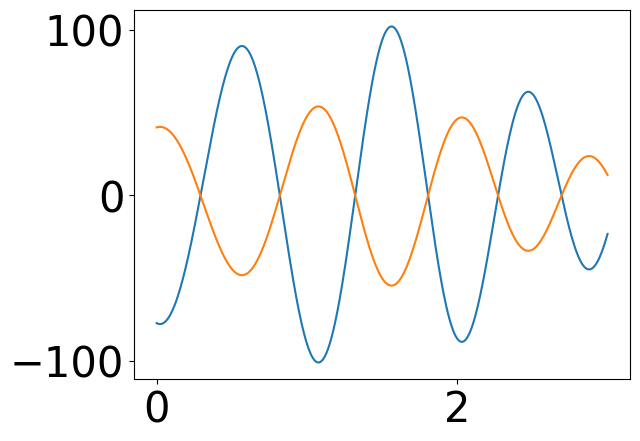

In [93]:
plt.plot(time_axis, scaled_lambda_t)

#### Add in the $\lambda_0$ for each AMPA and GABA

In [94]:
# Define the lambda_0 values for AMPA and GABA
lambda_0_AMPA = 500
lambda_0_GABA = 120


# Adding lambda_0_AMPA to the first subprocess (AMPA) and lambda_0_GABA to the second subprocess (GABA)
cif_final_AMPA = scaled_lambda_t[:, 0] + lambda_0_AMPA
cif_final_GABA = scaled_lambda_t[:, 1] + lambda_0_GABA

# Stacked CIF (AMPA THEN GABA)
cif_final = np.hstack((cif_final_AMPA.reshape(-1, 1), cif_final_GABA.reshape(-1, 1)))

## Testing

In [95]:
def test_cif_final():
    try:
        cif_final
        cif_final_AMPA
        cif_final_GABA
    except NameError as e:
        raise NameError(f"Required variable is not defined: {e}")

    # Proceed with the tests if variables are defined
    assert (
        cif_final[:, 0] == cif_final_AMPA
    ).all(), "Mismatch between cif_final[:, 0] and cif_final_AMPA"
    assert (
        cif_final[:, 1] == cif_final_GABA
    ).all(), "Mismatch between cif_final[:, 1] and cif_final_GABA"

    # Test that both dimensions of cif_final are strictly positive
    assert (
        cif_final.shape[0] > 0 and cif_final.shape[1] > 0
    ), "cif_final dimensions must be strictly positive"

    print("All tests passed!")


# Call the test function
test_cif_final()

All tests passed!


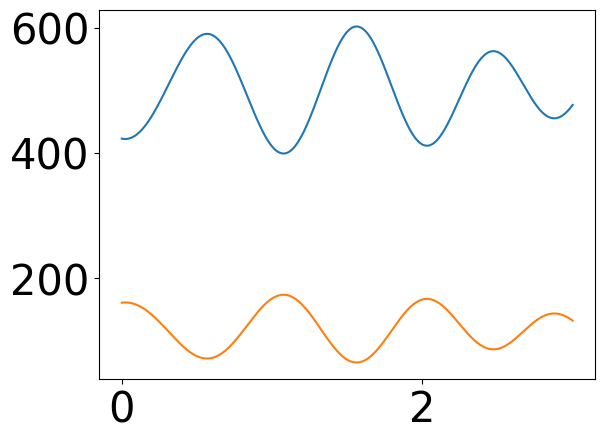

In [96]:
plt.plot(time_axis, cif_final)

In [97]:
cif_final.shape

(3000, 2)

In [98]:
min(np.real(cif_final[:, 1]))

65.58985946077581

## Find index of greatest distance when AMPA and GABA are each highest

In [99]:
# Compute the differences to find the highest and furthest points
difference_AMPA_GABA = (
    cif_final[:, 0] - cif_final[:, 1]
)  # Difference between AMPA and GABA

# Find the indices where AMPA is the highest and furthest from GABA and vice versa
ampa_highest_index = np.argmax(difference_AMPA_GABA)
gaba_highest_index = np.argmin(difference_AMPA_GABA)

# Print the indices
print(f"Index where AMPA is highest and furthest from GABA: {ampa_highest_index}")
print(f"Index where GABA is highest and furthest from AMPA: {gaba_highest_index}")

Index where AMPA is highest and furthest from GABA: 1562
Index where GABA is highest and furthest from AMPA: 1076


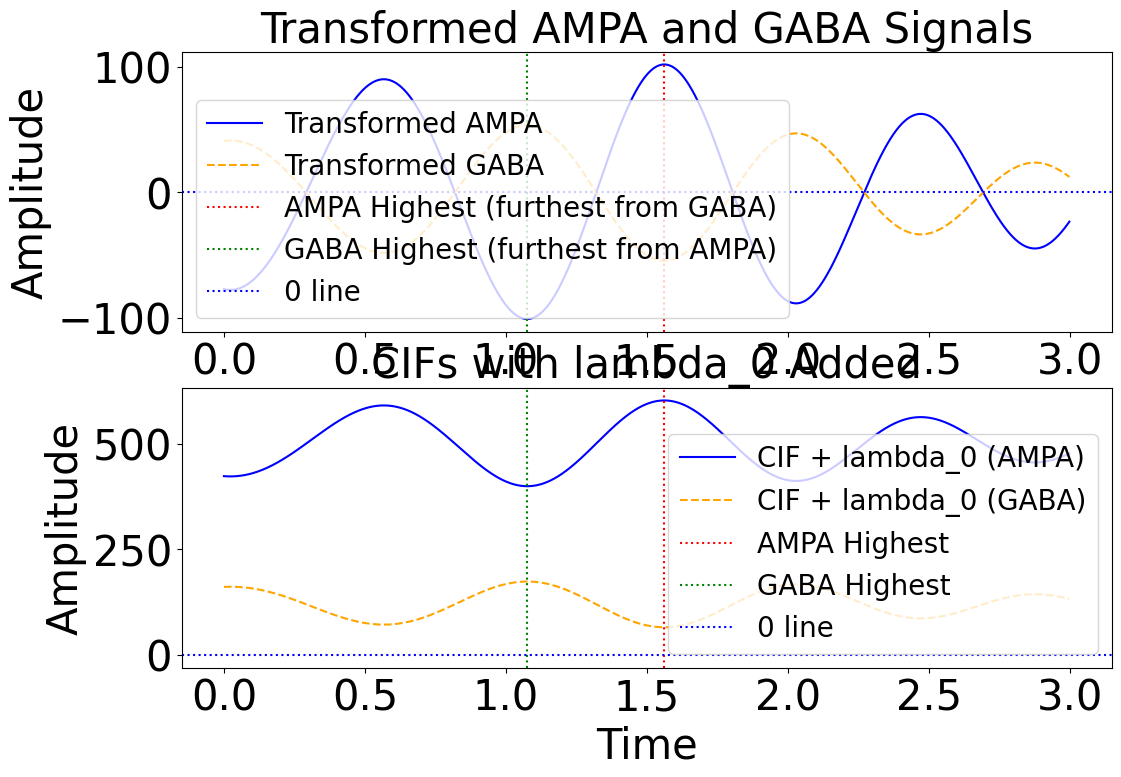

In [100]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot the transformed AMPA and GABA signals
plt.subplot(2, 1, 1)
plt.plot(time_axis, scaled_lambda_t[:, 0], label="Transformed AMPA", color="blue")
plt.plot(
    time_axis,
    scaled_lambda_t[:, 1],
    label="Transformed GABA",
    color="orange",
    linestyle="--",
)
plt.axvline(
    x=time_axis[ampa_highest_index],
    color="red",
    linestyle=":",
    label="AMPA Highest (furthest from GABA)",
)
plt.axvline(
    x=time_axis[gaba_highest_index],
    color="green",
    linestyle=":",
    label="GABA Highest (furthest from AMPA)",
)
plt.axhline(y=0, color="blue", linestyle=":", label="0 line")
plt.title("Transformed AMPA and GABA Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot the actual CIFs with lambdas added
plt.subplot(2, 1, 2)
plt.plot(time_axis, cif_final[:, 0], label="CIF + lambda_0 (AMPA)", color="blue")
plt.plot(
    time_axis,
    cif_final[:, 1],
    label="CIF + lambda_0 (GABA)",
    color="orange",
    linestyle="--",
)
plt.axvline(
    x=time_axis[ampa_highest_index], color="red", linestyle=":", label="AMPA Highest"
)
plt.axvline(
    x=time_axis[gaba_highest_index], color="green", linestyle=":", label="GABA Highest"
)
plt.axhline(y=0, color="blue", linestyle=":", label="0 line")
plt.title("CIFs with lambda_0 Added")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [101]:
fpp   = FilteredPointProcess(
    model=model_1,
    filters={"GABA": "GABA", "AMPA": "AMPA", "1/f": "1/f"},
    filter_params=None
)

## Calculating spectrum ($S_{field}$ for bivariate Cox model)

Final Spectrum:
 [2.04164920e-12+0.j 2.04181165e-12+0.j 2.04197411e-12+0.j ...
 2.04213659e-12+0.j 2.04197411e-12+0.j 2.04181165e-12+0.j]


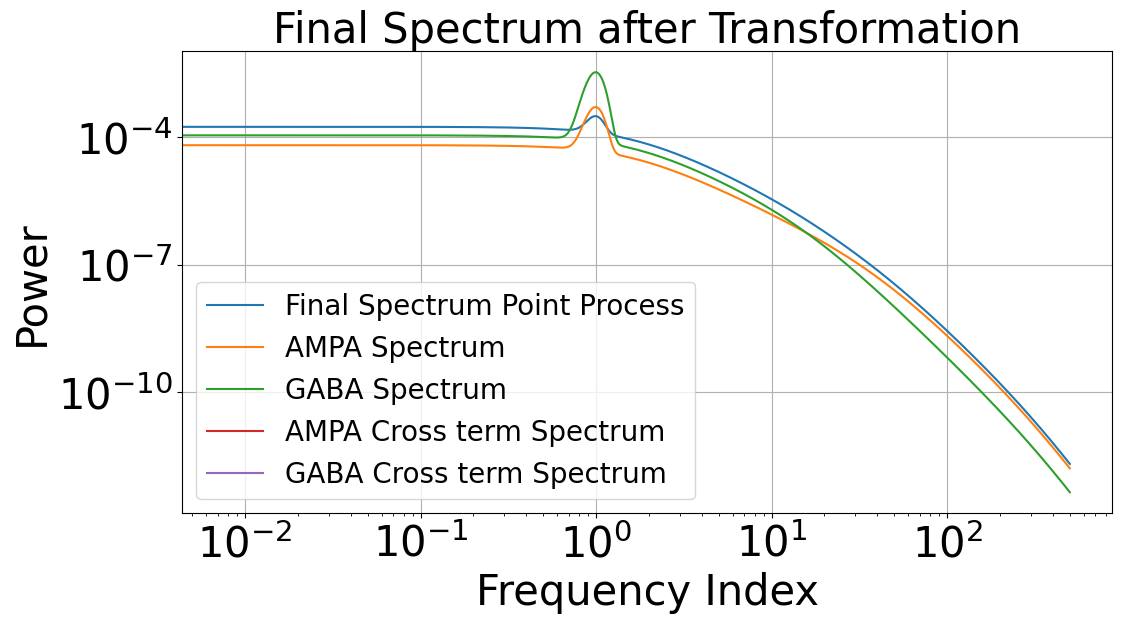

In [102]:
import numpy as np
import matplotlib.pyplot as plt

n_freqs = model_1.frequencies.shape[0]
S_ampa = model_1.cif.PSD

S_gaba = S_ampa

kappa = (
    (
        transform_vector[0] ** 2
        * fpp.filter_instances['AMPA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    + (
        transform_vector[0]
        * np.conj(transform_vector[1])
        * fpp.filter_instances['AMPA'].kernel_density_not_squared
        * np.conj(fpp.filter_instances['GABA'].kernel_density_not_squared)
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    + (
        transform_vector[1]
        * np.conj(transform_vector[0])
        * fpp.filter_instances['GABA'].kernel_density_not_squared
        * np.conj(fpp.filter_instances['AMPA'].kernel_density_not_squared)
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    + (
        transform_vector[1] ** 2
        * fpp.filter_instances['GABA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
)

overall_spectrum = (
    kappa * S_ampa
    + (
        lambda_0_AMPA
        * fpp.filter_instances['AMPA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    + (
        lambda_0_GABA
        * fpp.filter_instances['GABA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
)
cross_term_1 = S_ampa * (
    transform_vector[0]
    * np.conj(transform_vector[1])
    * fpp.filter_instances['AMPA'].kernel_density_not_squared
    * np.conj(fpp.filter_instances['GABA'].kernel_density_not_squared)
    * fpp.filter_instances['1/f'].kernel_spectrum
)
cross_term_2 = S_gaba * (
    transform_vector[1]
    * np.conj(transform_vector[0])
    * fpp.filter_instances['GABA'].kernel_density_not_squared
    * np.conj(fpp.filter_instances['AMPA'].kernel_density_not_squared)
    * fpp.filter_instances['1/f'].kernel_spectrum
)

print("Final Spectrum:\n", overall_spectrum)


frequencies = np.abs(model_1.frequencies)

panel_1_total_spectrum = overall_spectrum
panel_1_AMPA_spectrum = (
    (S_ampa + lambda_0_AMPA)
    * fpp.filter_instances['AMPA'].kernel_spectrum
    * fpp.filter_instances['1/f'].kernel_spectrum
)
panel_1_GABA_spectrum = (
    (S_gaba + lambda_0_GABA)
    * fpp.filter_instances['GABA'].kernel_spectrum
    * fpp.filter_instances['1/f'].kernel_spectrum
)


# Plot the final spectrum
plt.figure(figsize=(12, 6))
plt.loglog(
    model_1.frequencies, overall_spectrum, label="Final Spectrum Point Process"
)
plt.loglog(model_1.frequencies, panel_1_AMPA_spectrum, label="AMPA Spectrum")
plt.loglog(model_1.frequencies, panel_1_GABA_spectrum, label="GABA Spectrum")
plt.loglog(model_1.frequencies, cross_term_1, label="AMPA Cross term Spectrum")
plt.loglog(model_1.frequencies, cross_term_2, label="GABA Cross term Spectrum")
plt.title("Final Spectrum after Transformation")
plt.xlabel("Frequency Index")
plt.ylabel("Power")
plt.legend()
plt.grid()
plt.show()

## Visualizing the cross-terms 

In [103]:
S_gaba * (transform_vector[1] * np.conj(transform_vector[0]))

array([-0., -0., -0., ..., -0., -0., -0.])

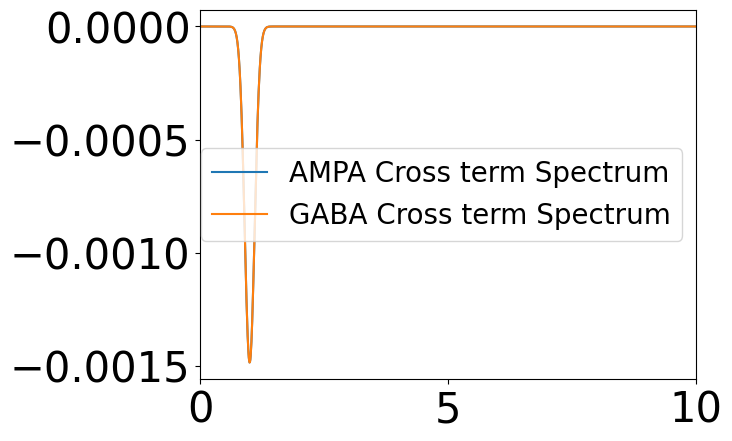

In [104]:
plt.plot(model_1.frequencies, cross_term_1, label="AMPA Cross term Spectrum")
plt.plot(model_1.frequencies, cross_term_2, label="GABA Cross term Spectrum")
plt.xlim([0, 10])
plt.legend()

## Spectra

In [105]:
# Initialize the final spectrum array
overall_spectrum = np.zeros((cif_final.shape[0], frequencies.shape[0]), dtype=complex)
ampa_component = np.zeros_like(overall_spectrum)
gaba_component = np.zeros_like(overall_spectrum)

In [106]:
for t in range(cif_final.shape[0]):
    ampa_component[t, :] = (
        cif_final[t, 0]
        * fpp.filter_instances['AMPA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    gaba_component[t, :] = (
        cif_final[t, 1]
        * fpp.filter_instances['GABA'].kernel_spectrum
        * fpp.filter_instances['1/f'].kernel_spectrum
    )
    overall_spectrum[t, :] = ampa_component[t, :] + gaba_component[t, :]

## Final Figure 

In [107]:
import numpy as np
import numdifftools as nd


def annotate_slope(
    ax,
    spectrum,
    frequencies,
    selected_frequencies=None,
    label_color="black",
    label_size=20,
    label_shift=(1.15, 1.15),
):
    """
    Annotates slopes at selected frequencies on a log-log scale for a given spectrum.
    """
    if selected_frequencies is None:
        selected_frequencies = np.logspace(
            np.log10(40), np.log10(450), 4
        )  # Automatically select 4 frequencies

    def log_log_slope(f, spectrum, frequencies):
        idx = np.argmin(np.abs(frequencies - f))  # Find the closest index
        d_log_spectrum = nd.Derivative(
            lambda log_f: np.log10(spectrum[np.argmin(np.abs(frequencies - 10**log_f))])
        )
        return d_log_spectrum(np.log10(frequencies[idx]))

    for f in selected_frequencies:
        idx = np.argmin(
            np.abs(frequencies - f)
        )  # Get closest index for the selected frequency
        slope = log_log_slope(
            frequencies[idx], spectrum, frequencies
        )  # Calculate slope
        ax.text(
            frequencies[idx] * label_shift[0],
            spectrum[idx] * label_shift[1],
            f"({slope:.2f})",
            fontsize=label_size,
            color=label_color,
        )

In [108]:
model_1.cif.NFFT

131072

/var/folders/y_/cv0__l8d15s4svd34bshwfm40000gn/T/ipykernel_60010/3670278733.py:258: RuntimeWarning: divide by zero encountered in log10
  logf  = np.log10(freqs)                                     # shape = (n_freqs,)


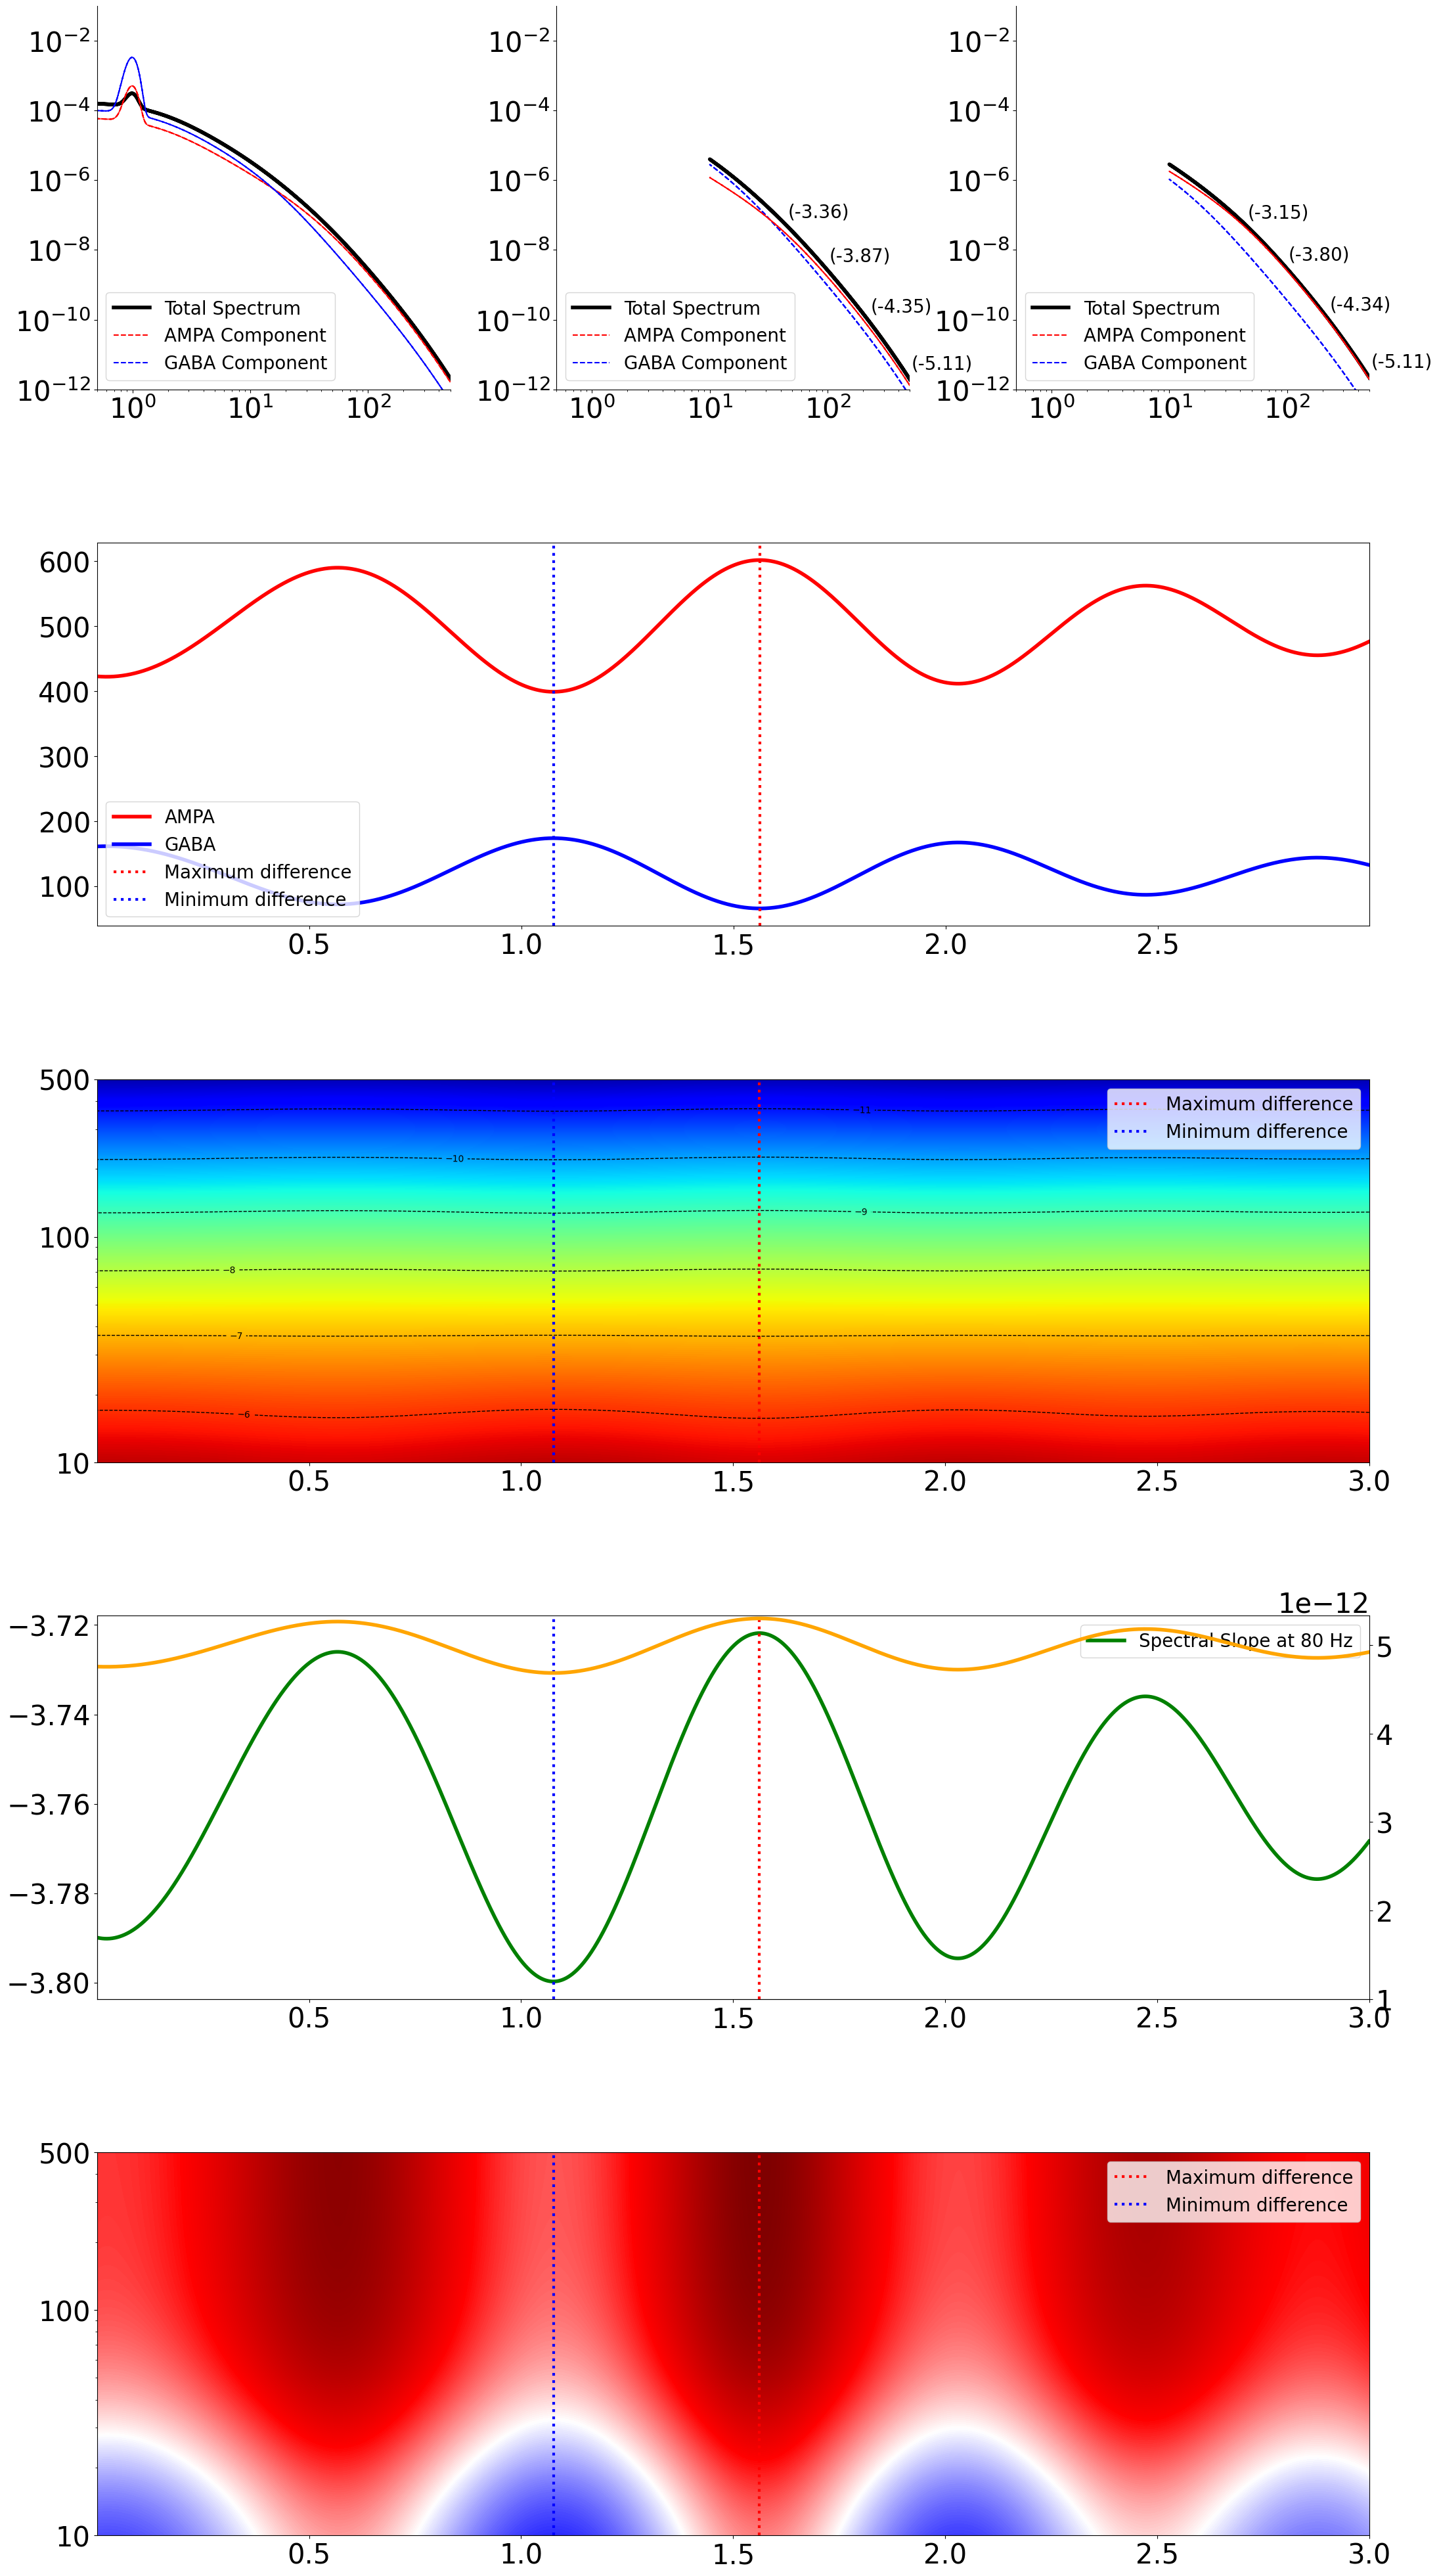

In [109]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

plt.rcParams["font.size"] = 30  # General font size
plt.rcParams["axes.titlesize"] = 30  # Title font size
plt.rcParams["axes.labelsize"] = 30  # Label font size
plt.rcParams["xtick.labelsize"] = 30  # X-tick label size
plt.rcParams["ytick.labelsize"] = 30  # Y-tick label size
plt.rcParams["legend.fontsize"] = 20  # Legend font size


def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"


def annotate_slope(
    ax,
    spectrum,
    frequencies,
    selected_frequencies=None,
    label_color="black",
    label_size=20,
    label_shift=(1.15, 1.15),
):
    if selected_frequencies is None:
        selected_frequencies = np.logspace(np.log10(40), np.log10(450), 4)

    def log_log_slope(f, spectrum, frequencies):
        idx = np.argmin(np.abs(frequencies - f))  # Find the closest index
        d_log_spectrum = nd.Derivative(
            lambda log_f: np.log10(spectrum[np.argmin(np.abs(frequencies - 10**log_f))])
        )
        return d_log_spectrum(np.log10(frequencies[idx]))

    for f in selected_frequencies:
        idx = np.argmin(
            np.abs(frequencies - f)
        )  # Get closest index for the selected frequency
        slope = log_log_slope(
            frequencies[idx], spectrum, frequencies
        )  # Calculate slope
        # Log-log shift (adjust on the log scale to avoid overlap)
        ax.text(
            frequencies[idx] * label_shift[0],
            spectrum[idx] * label_shift[1],
            f"({slope:.2f})",
            fontsize=label_size,
            color=label_color,
        )


def spectral_slope_at_frequency(spectrum_log_power, frequencies, f_target):
    def log_spectrum(log_f):
        freq = 10**log_f
        idx = np.argmin(np.abs(frequencies - freq))
        return spectrum_log_power[idx]

    # Compute the derivative at log(f_target)
    d_log_spectrum = nd.Derivative(log_spectrum)
    slope = d_log_spectrum(np.log10(f_target))
    return slope


fig = plt.figure(figsize=(25, 50))
gs = GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])


# Row 1: Theoretical Power Spectrum, AMPA Highest Index, GABA Highest Index
gs_top = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0])

# Theoretical Power Spectrum
ax1 = fig.add_subplot(gs_top[0])
ax1.loglog(
    frequencies,
    np.real(panel_1_total_spectrum),
    label="Total Spectrum",
    color="black",
    linewidth=4,
)
ax1.loglog(
    frequencies,
    np.real(panel_1_AMPA_spectrum),
    label="AMPA Component",
    color="red",
    linestyle="--",
)
ax1.loglog(
    frequencies,
    np.real(panel_1_GABA_spectrum),
    label="GABA Component",
    color="blue",
    linestyle="--",
)
ax1.legend(loc="lower left")
ax1.set_xlim(0.5, 500)
ax1.set_ylim(bottom=1e-12, top=1e-1)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# AMPA Highest Index
ax4_1 = fig.add_subplot(gs_top[2])
ax4_1.loglog(
    frequencies[frequencies >= 10],
    np.real(overall_spectrum[ampa_highest_index, frequencies >= 10]),
    label="Total Spectrum",
    color="black",
    linewidth=4,
)
ax4_1.loglog(
    frequencies[frequencies >= 10],
    np.real(ampa_component[ampa_highest_index, frequencies >= 10]),
    label="AMPA Component",
    color="red",
    linestyle="--",
    zorder=5,
)
ax4_1.loglog(
    frequencies[frequencies >= 10],
    np.real(gaba_component[ampa_highest_index, frequencies >= 10]),
    label="GABA Component",
    color="blue",
    linestyle="--",
)
ax4_1.legend(loc="lower left")
ax4_1.spines["top"].set_visible(False)
ax4_1.spines["right"].set_visible(False)
ax4_1.set_xlim(0.5, 500)
ax4_1.set_ylim(bottom=1e-12, top=1e-1)

annotate_slope(
    ax4_1,
    np.real(overall_spectrum[ampa_highest_index, frequencies >= 10]),
    frequencies[frequencies >= 10],
)

# GABA Highest Index
ax4_2 = fig.add_subplot(gs_top[1])
ax4_2.loglog(
    frequencies[frequencies >= 10],
    np.real(overall_spectrum[gaba_highest_index, frequencies >= 10]),
    label="Total Spectrum",
    color="black",
    linewidth=4,
)
ax4_2.loglog(
    frequencies[frequencies >= 10],
    np.real(ampa_component[gaba_highest_index, frequencies >= 10]),
    label="AMPA Component",
    color="red",
    linestyle="--",
    zorder=5,
)
ax4_2.loglog(
    frequencies[frequencies >= 10],
    np.real(gaba_component[gaba_highest_index, frequencies >= 10]),
    label="GABA Component",
    color="blue",
    linestyle="--",
)
ax4_2.legend(loc="lower left")
ax4_2.spines["top"].set_visible(False)
ax4_2.spines["right"].set_visible(False)
ax4_2.set_xlim(0.5, 500)
ax4_2.set_ylim(bottom=1e-12, top=1e-1)

annotate_slope(
    ax4_2,
    np.real(overall_spectrum[gaba_highest_index, frequencies >= 10]),
    frequencies[frequencies >= 10],
)

# Row 2: CIF Plot
ax2 = plt.subplot(gs[1])
ax2.plot(time_axis, cif_final[:, 0].real, label="AMPA", color="red", linewidth=4)
ax2.plot(time_axis, cif_final[:, 1].real, label="GABA", color="blue", linewidth=4)
ax2.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax2.axvline(
    x=time_axis[ampa_highest_index],
    color="red",
    linestyle=":",
    linewidth=3,
    label="Maximum difference",
)
ax2.axvline(
    x=time_axis[gaba_highest_index],
    color="blue",
    linestyle=":",
    linewidth=3,
    label="Minimum difference",
)
ax2.set_xlim(time_axis.min(), time_axis.max())
ax2.legend(loc="lower left")

# Row 3: Unnormalized Spectrogram
ax3 = plt.subplot(gs[2])
overall_spectrum_dB = np.log10(np.real(overall_spectrum))
cax3 = ax3.imshow(
    np.real(overall_spectrum_dB.T[model_1.cif.NFFT // 2 :]),
    origin="lower",
    cmap="jet",
    aspect="auto",
    extent=[
        0,
        overall_spectrum_dB.shape[0] / 1000,
        frequencies.min(),
        frequencies.max(),
    ],
    vmin=-12,
    vmax=-5,
)
ax3.axvline(
    x=ampa_highest_index / 1000,
    color="red",
    linestyle=":",
    linewidth=3,
    label="Maximum difference",
)
ax3.axvline(
    x=gaba_highest_index / 1000,
    color="blue",
    linestyle=":",
    linewidth=3,
    label="Minimum difference",
)
ax3.set_yscale("log")
ax3.set_yticks([10, 100, 500])
ax3.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax3.set_ylim(10, 500)
ax3.get_yaxis().set_major_formatter(ScalarFormatter())
ax3.legend()

# Overlay contours on ax3
contour_levels = np.arange(-12, -5, 1)  # Define contour levels
contours = ax3.contour(
    np.real(overall_spectrum_dB.T[model_1.cif.NFFT // 2 :]),
    levels=contour_levels,
    origin="lower",
    extent=[
        0,
        overall_spectrum_dB.shape[0] / 1000,
        frequencies.min(),
        frequencies.max(),
    ],
    linewidths=1,
    colors="k",
)
ax3.clabel(contours, inline=True, fontsize=10)

# half-spectrum start index
start = model_1.cif.NFFT // 2
freqs = frequencies[start:]                               

# log-power and log-frequency arrays
logP  = np.log10( np.real(overall_spectrum[:, start:]) )   # shape = (n_times, n_freqs)
logf  = np.log10(freqs)                                     # shape = (n_freqs,)

# central-difference on log–log grid
dlogf = np.gradient(logf)                                   # ∂logf/∂bin
dlogP = np.gradient(logP, axis=1)                           # ∂logP/∂bin

# slope = ∂logP/∂logf at each time & freq
slopes = dlogP / dlogf[np.newaxis, :]                       # (n_times, n_freqs)

# pick out the 80 Hz column
ix80 = np.argmin(np.abs(freqs - 80))
slopes_over_time = slopes[:, ix80]

# Row 4: Spectral Slope at 80 Hz Over Time
ax6 = plt.subplot(gs[3])

# Plot the spectral slope
ax6.plot(
    time_axis,
    slopes_over_time,
    color="green",
    linewidth=4,
    label="Spectral Slope at 80 Hz",
)
ax6.axvline(x=time_axis[ampa_highest_index], color="red", linestyle=":", linewidth=3)
ax6.axvline(x=time_axis[gaba_highest_index], color="blue", linestyle=":", linewidth=3)
ax6.legend(loc="best")
ax6.set_xlim(time_axis.min(), time_axis.max())
ax6.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax6.spines["top"].set_visible(False)
ax6.spines["right"].set_visible(False)

# Create a twin y-axis for 80 Hz power
ax6_power = ax6.twinx()

# Extract power values at 80 Hz from the overall spectrum
freq_index_80Hz = np.argmin(np.abs(freqs - 80))  
power_at_80Hz = np.real(
    overall_spectrum[:, freq_index_80Hz]
)  

# Plot power at 80 Hz on the twin y-axis
ax6_power.plot(
    time_axis, power_at_80Hz, color="orange", linewidth=4, label="Power at 80 Hz"
)
ax6_power.yaxis.label.set_color("orange")
ax6_power.set_ylim(bottom=1e-12)
ax6_power.spines["right"].set_visible(True)

# Row 5: Log(AMPA) - Log(GABA) Spectrogram
ax5 = plt.subplot(gs[4])

# Compute log(AMPA) - log(GABA)
ampa_log_power = np.log10(np.abs(ampa_component))
gaba_log_power = np.log10(np.abs(gaba_component))
log_ratio_spectrogram = ampa_log_power - gaba_log_power

max_abs_value = np.max(np.abs(log_ratio_spectrogram.T[model_1.cif.NFFT // 2 :]))

# Plot the log ratio spectrogram using a divergent colormap
cax5 = ax5.imshow(
    np.real(log_ratio_spectrogram.T[model_1.cif.NFFT // 2 :]),
    origin="lower",
    cmap="seismic",
    aspect="auto",
    extent=[
        0,
        overall_spectrum_dB.shape[0] / 1000,
        frequencies.min(),
        frequencies.max(),
    ],
    vmin=-max_abs_value,
    vmax=max_abs_value,
)
ax5.axvline(
    x=ampa_highest_index / 1000,
    color="red",
    linestyle=":",
    linewidth=3,
    label="Maximum difference",
)
ax5.axvline(
    x=gaba_highest_index / 1000,
    color="blue",
    linestyle=":",
    linewidth=3,
    label="Minimum difference",
)
ax5.set_yscale("log")
ax5.set_yticks([10, 100, 500])
ax5.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax5.set_ylim(10, 500)
ax5.get_yaxis().set_major_formatter(ScalarFormatter())
ax5.legend()

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)


plt.show()

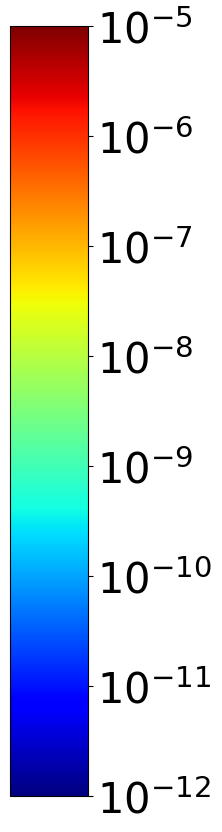

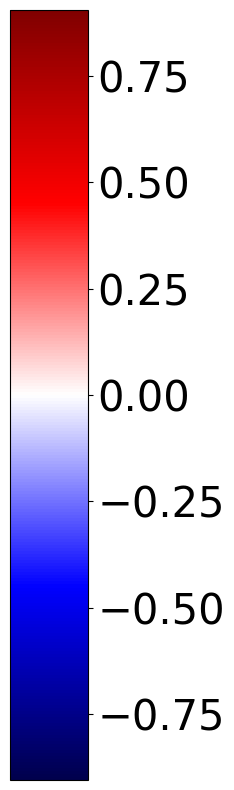

In [114]:
# Unnormalized Spectrogram Color Bar (for ax3)
fig_cbar1, ax_cbar1 = plt.subplots(figsize=(1, 10))
cbar1 = fig.colorbar(cax3, cax=ax_cbar1, orientation="vertical")
cbar1.set_ticks([-12, -11, -10, -9, -8, -7, -6, -5])
cbar1.set_ticklabels([f"$10^{{{int(tick)}}}$" for tick in cbar1.get_ticks()])
plt.show()

# Normalized Spectrogram Color Bar (for ax5)
fig_cbar2, ax_cbar2 = plt.subplots(figsize=(1, 10))
cbar2 = fig.colorbar(cax5, cax=ax_cbar2, orientation="vertical")



plt.show()

In [113]:
import numpy as np

# 1) Restrict to the same x‐range you plot in Panel B:
mask   = frequencies >= 10
freqsB = frequencies[mask]

# 2) Pull out the two curves at your chosen time‐index:
aB = np.real(ampa_component[gaba_highest_index, mask])
gB = np.real(gaba_component[gaba_highest_index, mask])

# 3) Compute their difference and look for a sign change
diff = aB - gB
# find all bins where diff flips sign:
idx = np.where(diff[:-1] * diff[1:] < 0)[0]

if len(idx) == 0:
    print("No crossing found in that range.")
else:
    # take the first crossing between bins idx[0] and idx[0]+1
    i = idx[0]
    f1, f2 = freqsB[i], freqsB[i+1]
    d1, d2 = diff[i], diff[i+1]
    # linear interp to zero:
    f_cross = f1 - d1 * (f2 - f1) / (d2 - d1)
    print(f"AMPA=GABA at ≈ {f_cross:.2f} Hz")


AMPA=GABA at ≈ 32.43 Hz


#